In [15]:
#!pip install gym==0.21
#!pip install tensorflow==1.14
#!pip install "ray[rllib]==0.8.4"



In [16]:
from ai_economist import foundation
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tutorials.utils import plotting  # plotting utilities for visualizing env. state

In [17]:
# Define a configuration (dictionary) for the "gather-trade-build" environment.

env_config_dict = {
    # ===== SCENARIO CLASS =====
    # Which Scenario class to use: the class's name in the Scenario Registry (foundation.scenarios).
    # The environment object will be an instance of the Scenario class.
    'scenario_name': 'layout_from_file/hetero_agents',
    
    # ===== COMPONENTS =====
    # Which components to use (specified as list of ("component_name", {component_kwargs}) tuples).
    #   "component_name" refers to the Component class's name in the Component Registry (foundation.components)
    #   {component_kwargs} is a dictionary of kwargs passed to the Component class
    # The order in which components reset, step, and generate obs follows their listed order below.
    'components': [
        # (1) Building houses
        ('Build', {
            'skill_dist':                   'pareto', 
            'payment_max_skill_multiplier': 3,
            'build_labor':                  10,
            'payment':                      10
        }),
        # (2) Trading collectible resources
        ('ContinuousDoubleAuction', {
            'max_bid_ask':    10,
            'order_labor':    0.25,
            'max_num_orders': 5,
            'order_duration': 50
        }),
        # (3) Movement and resource collection
        ('Gather', {
            'move_labor':    1,
            'collect_labor': 1,
            'skill_dist':    'pareto'
        }),
        # (4) Planner
        ('PeriodicBracketTax', {
            'period':          250,
            'bracket_spacing': 'us-federal',
            'usd_scaling':     1000,
            'disable_taxes':   False
        })
    ],
    
    # ===== SCENARIO CLASS ARGUMENTS =====
    # (optional) kwargs that are added by the Scenario class (i.e. not defined in BaseEnvironment)
    'env_layout_file': 'quadrant_25x25_20each_30clump.txt',
    'starting_agent_coin': 10,
    'fixed_four_skill_and_loc': True,
    
    # ===== STANDARD ARGUMENTS ======
    # kwargs that are used by every Scenario class (i.e. defined in BaseEnvironment)
    'n_agents': 3,          # Number of non-planner agents (must be > 1)
    'world_size': [25, 25], # [Height, Width] of the env world
    'episode_length': 759, # Number of timesteps per episode
    
    # In multi-action-mode, the policy selects an action for each action subspace (defined in component code).
    # Otherwise, the policy selects only 1 action.
    'multi_action_mode_agents': False,
    'multi_action_mode_planner': True,
    
    # When flattening observations, concatenate scalar & vector observations before output.
    # Otherwise, return observations with minimal processing.
    'flatten_observations': True,
    # When Flattening masks, concatenate each action subspace mask into a single array.
    # Note: flatten_masks = True is required for masking action logits in the code below.
    'flatten_masks': True,
    
    # How often to save the dense logs
    'dense_log_frequency': 1,
    
    # new
    "env_weighting" :[.01, 0.004, -.002],#needs to have len of n agents
    #{0: -0.2625000000000002, 1: -0.05250000000000021, 2: -0.2625000000000002, 'p': 0.0}

    "equ_weighting": [.5, -.1, .1],
    "mobile_agent_class": "HeteroMobileAgent",#HeteroMobileAgent, BasicMobileAgent
    
}

In [18]:
env = foundation.make_env_instance(**env_config_dict)
obs = env.reset()


Coin
Stone
Wood


In [19]:


for agent in env.world.agents:
    print('Agent {} coin-per-house: {}  evironment weighting: {}  equality weighting: {}'.format(
        agent.idx, agent.state['build_payment'], agent.env_weighting, agent.equality
        ))

Agent 0 coin-per-house: 14.87301326696934  evironment weighting: 0.01  equality weighting: 0.5
Agent 1 coin-per-house: 11.81445367502974  evironment weighting: 0.004  equality weighting: -0.1
Agent 2 coin-per-house: 20.79461173785582  evironment weighting: -0.002  equality weighting: 0.1


In [20]:
env.world.agents[0].action_spaces

50

In [21]:
# Note: The code for sampling actions (this cell), and playing an episode (below) are general.  
# That is, it doesn't depend on the Scenario and Component classes used in the environment!

def sample_random_action(agent, mask):
    """Sample random UNMASKED action(s) for agent."""
    # Return a list of actions: 1 for each action subspace
    if agent.multi_action_mode:
        split_masks = np.split(mask, agent.action_spaces.cumsum()[:-1])
        return [np.random.choice(np.arange(len(m_)), p=m_/m_.sum()) for m_ in split_masks]

    # Return a single action
    else:
        return np.random.choice(np.arange(agent.action_spaces), p=mask/mask.sum())

def sample_random_actions(env, obs):
    """Samples random UNMASKED actions for each agent in obs."""
        
    actions = {
        a_idx: sample_random_action(env.get_agent(a_idx), a_obs['action_mask'])
        for a_idx, a_obs in obs.items()
    }

    return actions

In [22]:
for i in range(10):
    
    actions = sample_random_actions(env, obs)
    print(actions)
    obs, rew, done, info = env.step(actions)
    #if any(rew.values()):
    #print(rew, done, info)

{'0': 10, '1': 3, '2': 8, 'p': [11, 2, 18, 8, 8, 9, 6]}
{'0': 23, '1': 4, '2': 25, 'p': [0, 0, 0, 0, 0, 0, 0]}
{'0': 48, '1': 31, '2': 37, 'p': [0, 0, 0, 0, 0, 0, 0]}
{'0': 3, '1': 24, '2': 26, 'p': [0, 0, 0, 0, 0, 0, 0]}
{'0': 48, '1': 28, '2': 49, 'p': [0, 0, 0, 0, 0, 0, 0]}
{'0': 47, '1': 36, '2': 45, 'p': [0, 0, 0, 0, 0, 0, 0]}
{'0': 24, '1': 5, '2': 40, 'p': [0, 0, 0, 0, 0, 0, 0]}
{'0': 0, '1': 46, '2': 5, 'p': [0, 0, 0, 0, 0, 0, 0]}
{'0': 48, '1': 46, '2': 0, 'p': [0, 0, 0, 0, 0, 0, 0]}
{'0': 24, '1': 47, '2': 24, 'p': [0, 0, 0, 0, 0, 0, 0]}


In [23]:
def do_plot(env, ax, fig):
    """Plots world state during episode sampling."""
    plotting.plot_env_state(env, ax)
    ax.set_aspect('equal')
    display.display(fig)
    display.clear_output(wait=True)

def play_random_episode(env, plot_every=100, do_dense_logging=False):
    """Plays an episode with randomly sampled actions.
    
    Demonstrates gym-style API:
        obs                  <-- env.reset(...)         # Reset
        obs, rew, done, info <-- env.step(actions, ...) # Interaction loop
    
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Reset
    obs = env.reset(force_dense_logging=do_dense_logging)

    # Interaction loop (w/ plotting)
    for t in range(env.episode_length):
        actions = sample_random_actions(env, obs)
        obs, rew, done, info = env.step(actions)

        if ((t+1) % plot_every) == 0:
            do_plot(env, ax, fig)

    if ((t+1) % plot_every) != 0:
        do_plot(env, ax, fig)        

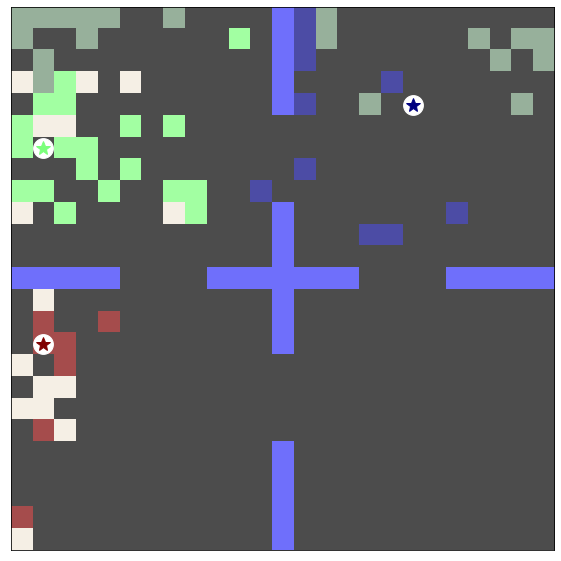

In [24]:
play_random_episode(env, plot_every=100)